In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
%matplotlib inline

from scipy.misc.pilutil import imread

In [24]:
sc = SparkSession \
    .builder \
    .appName("death_map") \
    .getOrCreate()

In [70]:
directory = "/user/pjs520/deaths/deaths/"
files = ["kill_match_stats_final_0.csv",
          "kill_match_stats_final_1.csv",
          "kill_match_stats_final_2.csv",
          "kill_match_stats_final_3.csv", "kill_match_stats_final_4.csv"]
deaths = None
for file in files:
    TempDeaths = spark.read.csv(directory+file,header='true')
    if deaths:
        deaths = deaths.union(TempDeaths)
    else:
        deaths = TempDeaths
        

file: kill_match_stats_final_0.csv , 13426348
file: kill_match_stats_final_1.csv , 26867237
file: kill_match_stats_final_2.csv , 40298289
file: kill_match_stats_final_3.csv , 53729620
file: kill_match_stats_final_4.csv , 65370475


In [71]:
deaths.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: string (nullable = true)
 |-- killer_position_x: string (nullable = true)
 |-- killer_position_y: string (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: string (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: string (nullable = true)
 |-- victim_position_x: string (nullable = true)
 |-- victim_position_y: string (nullable = true)



In [72]:
deaths_df = deaths.filter(deaths.map == "ERANGEL")
deaths_df = deaths_df.select('victim_position_x','victim_position_y','killer_position_x','killer_position_y')
deaths_df = deaths_df.dropna(subset=('victim_position_x','victim_position_y','killer_position_x','killer_position_y'))
deaths_df = deaths_df.withColumn("victim_position_x", deaths["victim_position_x"].cast(DoubleType()))
deaths_df = deaths_df.withColumn("victim_position_y", deaths["victim_position_y"].cast(DoubleType()))
deaths_df = deaths_df.withColumn('victim_position_x', deaths_df.victim_position_x*4096/800000)
deaths_df = deaths_df.withColumn('victim_position_y', deaths_df.victim_position_y*4096/800000)
deaths_df = deaths_df.select('victim_position_x','victim_position_y')
deaths_df.printSchema()

root
 |-- victim_position_x: double (nullable = true)
 |-- victim_position_y: double (nullable = true)



In [59]:
deaths_df.count()

10123879

In [73]:
deaths_df.dropna(how='any')

DataFrame[victim_position_x: double, victim_position_y: double]

In [74]:
#df_second_er = deaths_df.toPandas()
deaths_df.write.csv('/user/pjs520/heatmap/deaths.csv', header=False)

In [75]:
df_second_er = pd.read_csv('/home/pjs520/heatmap_deaths.csv', header=None)

In [76]:
df_second_er.columns = ['victim_position_x','victim_position_y']
df_second_er.head(5)

victim_position_x  victim_position_y
0        2546.613248        1697.424384
1        2548.835328        1699.744256
2        2354.267648        2121.862656
3        2495.714304        1779.973120
4        2524.382208        2224.425472

In [77]:
plot_data_er = df_second_er[['victim_position_x', 'victim_position_y']].values

In [78]:
def heatmap(x, y, s, bins=100):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [79]:
bg = imread('/home/pjs520/datasets/erangel.jpg')

/share/apps/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


## The red dots show where the deaths tend to concentrate

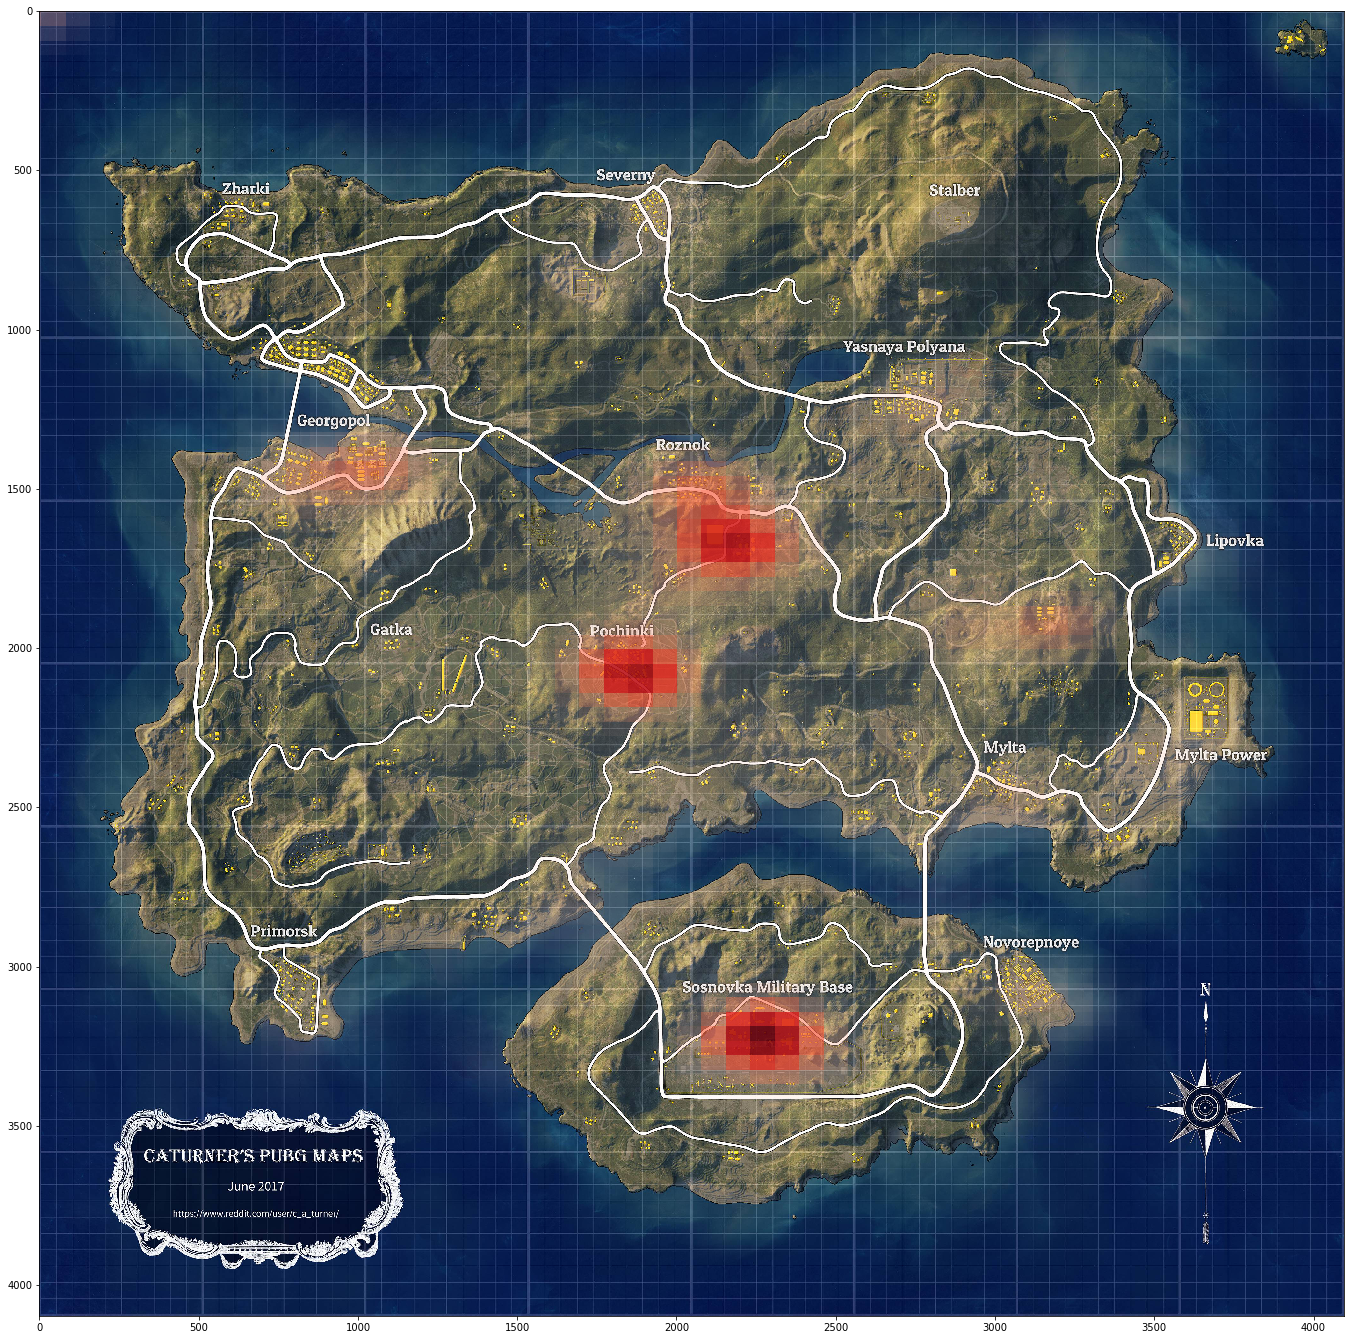

In [80]:
hmap, extent = heatmap(plot_data_er[:,0], plot_data_er[:,1], 1.5)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*1.5, 0.0, 1.)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.Reds(colors)
colors[..., -1] = alphas

fig, ax = plt.subplots(figsize=(24,24))
ax.set_xlim(0, 4096); ax.set_ylim(0, 4096)
ax.imshow(bg)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=0.9)
#plt.scatter(plot_data_er[:,0], plot_data_er[:,1])
plt.gca().invert_yaxis()